In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from pathlib import Path

from astropy import units as u
from astropy.table import Table 
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time, TimeDeltaSec

import glowing_waffles.differential_photometry as gwdf


## Change the settings below as appropriate for your images

In [3]:
# This can be a relative or absolute path
# On Windows make this a "raw" string by putting an r before the string, otherwise
# Python interprets the backslashes as escapotential energy sequences.
# Windows example:
# directory_with_images = r'C:\path\to\my\files'
#
# Mac/Linux example:
directory_with_images = '2019-06-01-reduced'

# If your magnitudes are in the same directory as the images then change to
# directory_with_magnitude_file = directory_with_images
directory_with_magnitude_file = '.'

# This only used to center to make a light curve of your object at the end of this
# notebook.
# If the object you have can't be looked up in simbad this cell will raise an error.
object_of_interest = 'TrES-4b'

if object_of_interest:
    obj_coords = SkyCoord.from_name(object_of_interest)
    
# can be any image from middle of sequence    
sample_image_for_finding_stars = 'tres-4-S001-R112-C001-r.fit'

input_photometry_file = '2019-06-01-TrES-4b-aperture-12.fits'

# Set the faintest stars to use in calibrating the magnitudes
# For the new camera (any nights in 2018) use 13
# For the old camera (any older nights) use 16
faintest_mag = 13

# Set the name of the apass column to use for calibration
#r_mag for the new camera
#Rmag for the old
apass_cal_mag = 'r_mag'

# Set the name of the column in our data file for our instrumental magnitude
# Should be mag_inst_r for the new camera, mag_inst_R for the old
feder_instrumental_mag = 'mag_inst_r'

# change this to the name of your input photometry file
output_photometry_file = '2019-06-01-TrES-4b-aperture-12' +'-transformed.fits'

# Set the location of our observatory
feder = EarthLocation("263.54672d", "46.86678d")

In [4]:
def func(image_directory, sample_image):
    ccd = CCDData.read(Path(image_directory) / sample_image)
    
    apass, apass_x, apass_y, apass_for_transform, in_apass_x, in_apass_y = gwdf.find_apass_stars(ccd)
    vsx, vsx_x, vsx_y, vsx_names = gwdf.find_known_variables(ccd)
    
    apass_all_coords = SkyCoord(apass['RAJ2000'], apass['DEJ2000'], unit='deg')
    apass_for_transform_coords = SkyCoord(apass_for_transform['RAJ2000'], apass_for_transform['DEJ2000'], unit='deg')
    
    return ccd , apass, apass_x, apass_y, apass_for_transform, in_apass_x, in_apass_y, vsx, vsx_x, vsx_y, vsx_names, apass_all_coords, apass_for_transform_coords 

In [5]:
ccd, apass, apass_x, apass_y, apass_for_transform, in_apass_x, in_apass_y, vsx, vsx_x, vsx_y, vsx_names, apass_all_coords, apass_for_transform_coords = func(directory_with_images, sample_image_for_finding_stars) 

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


## Add column for R filter in case we need it

In [6]:
apass['Rmag'] = gwdf.filter_transform(apass, 'R', r='r_mag', i='i_mag', transform='ivezic')
apass_for_transform['Rmag'] = gwdf.filter_transform(apass_for_transform, 'R', r='r_mag', i='i_mag', transform='ivezic')

apass['Imag'] = gwdf.filter_transform(apass, 'I', r='r_mag', i='i_mag', transform='ivezic')
apass_for_transform['Imag'] = gwdf.filter_transform(apass_for_transform, 'I', r='r_mag', i='i_mag', transform='ivezic')

## Read in the data file

The `read_data` function also gets the "star_id" for object of interest.

In [7]:
#read in data file and get star_id for object of interest
def read_data(mag_directory, photometry_input):
    input_mags = Table.read(Path(mag_directory) / photometry_input)
    
    if object_of_interest:
        input_coords = SkyCoord(input_mags['RA'], input_mags['Dec'])
        idx, d2d, d3d = obj_coords.match_to_catalog_sky(input_coords)

        object_of_interest_id = input_mags['star_id'][idx]
        print(object_of_interest_id)
        
    return input_mags, input_coords, idx, d2d, d3d, object_of_interest_id

input_mags, input_coords, idx, d2d, d3d, object_of_interest_id = read_data(directory_with_magnitude_file, input_photometry_file)

245


In [8]:
input_mags['mag_cal'] = np.zeros(len(input_mags))
input_mags['zero_point'] = np.zeros(len(input_mags))
input_mags['color_term'] = np.zeros(len(input_mags))
input_mags['t_start_tdb'] = np.zeros(len(input_mags))
input_mags['t_mid_tdb'] = np.zeros(len(input_mags))

mags_grouped = input_mags.group_by('file')

In [9]:
input_mags.colnames

['id',
 'xcenter',
 'ycenter',
 'aperture_sum',
 'annulus_sum',
 'RA',
 'Dec',
 'sky_per_pix_avg',
 'sky_per_pix_med',
 'sky_per_pix_std',
 'aperture',
 'aperture_area',
 'annulus_inner',
 'annulus_outer',
 'annulus_area',
 'exposure',
 'date-obs',
 'night',
 'aperture_net_flux',
 "mag_inst_r'",
 'airmass',
 'filter',
 'file',
 'star_id',
 'mag_error',
 'mag_cal',
 'zero_point',
 'color_term',
 't_start_tdb',
 't_mid_tdb']

In [10]:
filter_names = {"r'": "r"}

In [11]:
print('On image...', end='')
for idx, our_mags in enumerate(mags_grouped.groups):
    print(str(idx) + '..', end='')
    filt = our_mags['filter'][0]
    input_mag_col = 'mag_inst_' + filt
    apass_col = filter_names[filt] + '_mag'
    new_mags, matches, transform = gwdf.transform_magnitudes(our_mags, apass, apass_for_transform, 
                                                faintest_mag_for_transform=faintest_mag,
                                                input_mag_colum=input_mag_col,
                                                catalog_mag_column=apass_col,
                                                catalog_color_column='B-V'
                                               )
    our_mags['mag_cal'][matches] = new_mags.data.filled(np.nan)
    our_mags['mag_cal'][~matches] = np.nan
    our_mags['zero_point'] = transform.parameters[0]
    our_mags['color_term'] = transform.parameters[1]
    t_utc = Time(our_mags['date-obs'], scale='utc', location=feder)
    our_coords = SkyCoord(our_mags['RA'], our_mags['Dec'])
    delta_t_tdb = t_utc.light_travel_time(our_coords)
    t_tdb = t_utc.tdb + delta_t_tdb
    t_tdb_mid = t_tdb + our_mags['exposure'] / 2
    our_mags['t_start_tdb'][:] = t_tdb.jd
    our_mags['t_mid_tdb'][:] = t_tdb_mid.jd

On image...0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..

In [12]:
mags_grouped.sort('t_start_tdb')

In [13]:
if object_of_interest:
    object_alone = mags_grouped[mags_grouped['star_id'] == object_of_interest_id]
    

## Identify known variables in the field 

### Do the matching and add VSX name column to output table

In [14]:
def match():
    mag_coords = SkyCoord(mags_grouped['RA'], mags_grouped['Dec'])
    vsx_coords = SkyCoord(vsx['RAJ2000'], vsx['DEJ2000'])
    vsx_idx, d2d, d3d = mag_coords.match_to_catalog_sky(vsx_coords)
    matches = d2d < 3 * u.arcsec
    
    vsx_names = np.array([''] * len(mags_grouped), dtype='S50')
    vsx_names[matches] = vsx['Name'][vsx_idx[matches]]
    mags_grouped['vsx_name'] = vsx_names
    
    return mag_coords, vsx_coords, vsx_idx, d2d, d3d, matches

## Write output to a file

In [15]:
mags_grouped.write(output_photometry_file)

OSError: File exists: 2019-06-01-TrES-4b-aperture-12-transformed.fits

## Graph transform coefficients


In [25]:
regrouped = mags_grouped.group_by('file')
agg_regrouped = regrouped.groups.aggregate(np.mean)
sum_regrouped = regrouped.groups.aggregate(np.sum)

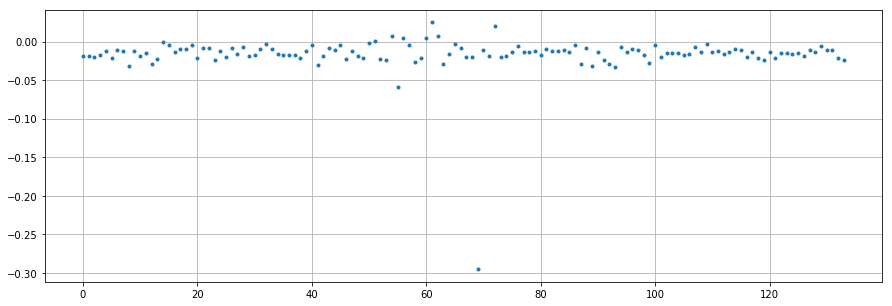

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(agg_regrouped['color_term'], '.')
#plt.ylim(-4, 2)
plt.grid()

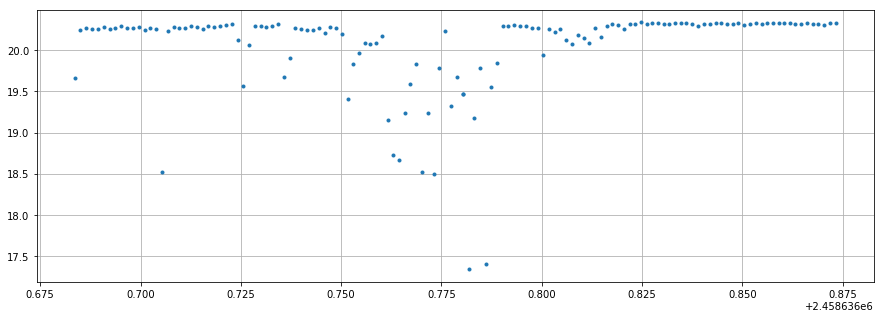

In [27]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(agg_regrouped['t_mid_tdb'], agg_regrouped['zero_point'], '.')
#plt.ylim(20, 21)

## Graph of your object, *uncalibrated* magnitudes

In [28]:
if not object_of_interest:
    raise ValueError('Remaining cells will work only if the object_of_interest is set to a non-empty string.')

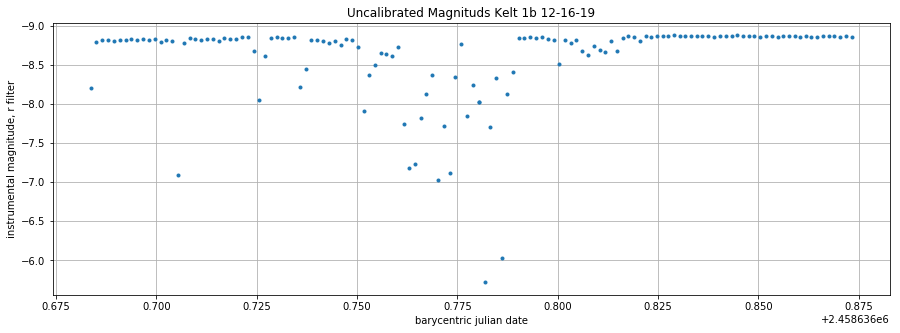

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(object_alone['t_mid_tdb'], object_alone["mag_inst_r'"], '.')
plt.ylim(reversed(plt.ylim()))
plt.title('Uncalibrated Magnituds Kelt 1b 12-16-19') #REPLACE THIS WITH MEANINGFUL TITLE
plt.ylabel('instrumental magnitude, r filter')
plt.xlabel('barycentric julian date')
plt.grid()

## Graph of your object, *calibrated* magnitudes

For an exoplanet transit, enter the ingress, midpoint and egress below. Uncomment the cells, fill in your date and time (UTC) and run. In the 3rd cell, uncomment the 2 lines to draw a line at the beginning and end of the transit. 

In [21]:
#start_time = Time("2018-12-17 04:07:00", scale='utc')
#mid_time = Time("2018-12-17 05:23:00", scale='utc')
#end_time = Time("2018-12-17 06:40:00", scale='utc')

In [22]:
#print(start_time.tdb.jd)
#print(mid_time.tdb.jd)
#print(end_time.tdb.jd)

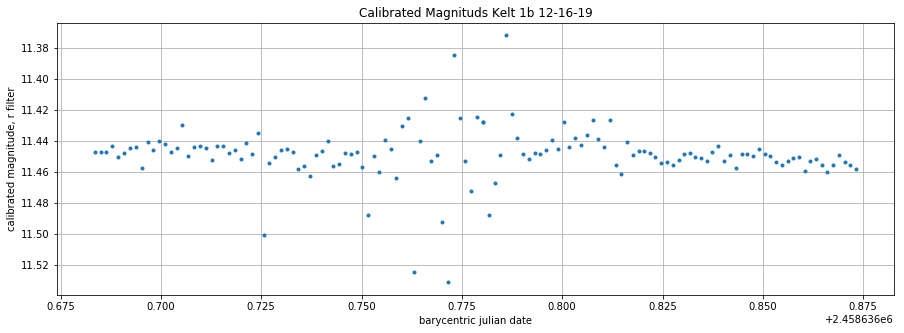

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(object_alone['t_mid_tdb'], object_alone['mag_cal'], '.')
#plt.axvline(x=start_time.tdb.jd)
#plt.axvline(x=end_time.tdb.jd)
plt.ylim(reversed(plt.ylim()))
plt.title('Calibrated Magnituds Kelt 1b 12-16-19') #REPLACE THIS WITH MEANINGFUL TITLE
plt.ylabel('calibrated magnitude, r filter')
plt.xlabel('barycentric julian date')
plt.grid()

In [33]:
comparison_flux = sum_regrouped["aperture_net_flux"] - object_alone["aperture_net_flux"]
ratio = object_alone["aperture_net_flux"] / comparison_flux

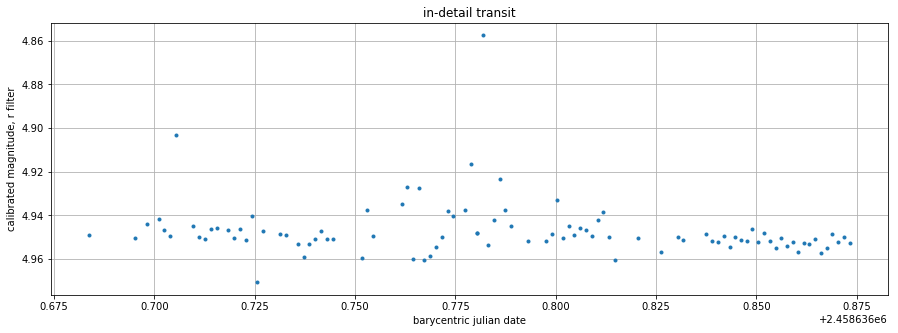

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(object_alone['t_mid_tdb'], -2.5 * np.log10(ratio), '.')
plt.ylim(reversed(plt.ylim()))
plt.title('in-detail transit')
plt.ylabel('calibrated magnitude, r filter')
plt.xlabel('barycentric julian date')
plt.grid()

Run this cell (only if you have uncommented the above cells) to graph an explanet transit from start to end to see more detail. If you run this cell without uncommenting the lines mentioned above, you will get an error.

NameError: name 'start_time' is not defined

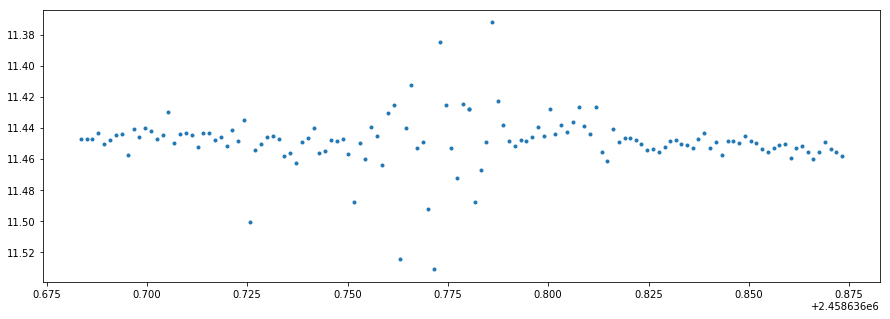

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(object_alone['t_mid_tdb'], object_alone['mag_cal'], '.')
plt.ylim(reversed(plt.ylim()))
plt.xlim(start_time.tdb.jd, end_time.tdb.jd)
plt.title('in-detail transit')
plt.ylabel('calibrated magnitude, r filter')
plt.xlabel('barycentric julian date')
plt.grid()